# Task 3: Predictive Analytics

## Feature selection

### Imports:

In [60]:
import pandas as pd
import numpy as np
import re
import datetime as dt #for working with times objects

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

### Weather data and la_set:

#### Reading in the weather data:

In [61]:
# read csv file
weather_data = pd.read_csv("weather_hourly_la.csv", low_memory = False)

#only keep 2019
weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])

weather_data = weather_data[weather_data['date_time'].dt.year == 2019]

#deleding the last hour of 2018
last_hour_2018 = pd.to_datetime('2019-01-01 00:00:00')
weather_data = weather_data[weather_data['date_time'] != last_hour_2018]

weather_data = weather_data.sort_values(by='date_time')

weather_data.reset_index(drop = True)


,date_time,max_temp,min_temp,precip
0,2019-01-01 01:00:00,15.6,15.6,0.0
1,2019-01-01 02:00:00,15.0,15.0,0.0
2,2019-01-01 03:00:00,15.0,15.0,0.0
3,2019-01-01 04:00:00,13.9,13.9,0.0
4,2019-01-01 05:00:00,12.2,12.2,0.0
...,...,...,...,...
8726,2019-12-31 19:00:00,20.0,20.0,0.0
8727,2019-12-31 20:00:00,20.6,20.6,0.0
8728,2019-12-31 21:00:00,21.1,21.1,0.0
8729,2019-12-31 22:00:00,21.7,21.7,0.0


#### Reading in the la_set:

In [62]:
la_set = pd.read_pickle("la_set.pkl")
la_set

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,exact_duration
0,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,3051,6468,Walk-up,2nd & Hill,7th & Broadway,0 days 00:07:00
1,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,3051,12311,Walk-up,2nd & Hill,7th & Broadway,0 days 00:06:00
2,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,5992,Walk-up,Main & 1st,Broadway & 9th,0 days 00:32:00
3,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,3075,5860,Walk-up,Main & 1st,Broadway & 9th,0 days 00:30:00
4,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,3075,6006,Walk-up,Main & 1st,Broadway & 9th,0 days 00:28:00
...,...,...,...,...,...,...,...,...,...
270650,2019-12-31 23:34:46,2019-12-31 23:42:28,3063,3069,12019,Walk-up,Pershing Square,Broadway & 3rd,0 days 00:07:42
270651,2019-12-31 23:41:52,2019-12-31 23:50:58,4491,3022,18912,Monthly Pass,Main & Winston,3rd & Santa Fe,0 days 00:09:06
270652,2019-12-31 23:43:19,2019-12-31 23:47:41,3051,3064,12298,Annual Pass,7th & Broadway,Grand & 8th,0 days 00:04:22
270653,2019-12-31 23:48:17,2019-12-31 23:53:55,3064,3074,19053,Annual Pass,Grand & 8th,Hope & Olympic,0 days 00:05:38


#### Getting the demand per hour over the whole year:

In [63]:
def get_total_hours (td):
    return (int)(td.total_seconds() / 3600)

def get_total_minute (td):
    return (int)(td.total_seconds() / 60)

In [64]:
#amount of bike rentings gouped by hours
time_zero = pd.to_datetime('2019-01-01 00:00:00')

hour_demand = pd.DataFrame({'amount': la_set.groupby(la_set['start_time'].apply(lambda x: x.replace(minute = 0, second= 0))).size()})

hour_demand.reset_index(inplace=True)
hour_demand = hour_demand.rename(columns = {'start_time':'date_time'})

one_hour = pd.to_timedelta('0 days 01:00:00')

hour_demand['date_time'] = hour_demand['date_time']+one_hour

hour_demand['hour_from_zero'] = hour_demand['date_time'].apply(lambda x: get_total_hours(x-time_zero))

hour_demand

,date_time,amount,hour_from_zero
0,2019-01-01 01:00:00,19,1
1,2019-01-01 02:00:00,8,2
2,2019-01-01 03:00:00,16,3
3,2019-01-01 04:00:00,2,4
4,2019-01-01 07:00:00,1,7
...,...,...,...
8345,2019-12-31 20:00:00,37,8756
8346,2019-12-31 21:00:00,41,8757
8347,2019-12-31 22:00:00,22,8758
8348,2019-12-31 23:00:00,20,8759


#### Merging the two datasets into one (via join):

In [65]:
# join demand and weather

weather_demand = pd.merge(weather_data, hour_demand, how="left", on=["date_time", "date_time"])


#replacing NaN in amount values with 0
weather_demand['amount'] = weather_demand['amount'].fillna(0)
#replacing NaN values with the actual hours from zero
weather_demand['hour_from_zero'] = weather_demand['hour_from_zero'].fillna(weather_demand['date_time'].apply(lambda x: get_total_hours(x-time_zero)))

#converting values to integer
weather_demand['precip'] = weather_demand['precip'].astype(int)
weather_demand['amount'] = weather_demand['amount'].astype(int)
weather_demand['hour_from_zero'] = weather_demand['hour_from_zero'].astype(int)


weather_demand.head(5)


,date_time,max_temp,min_temp,precip,amount,hour_from_zero
0,2019-01-01 01:00:00,15.6,15.6,0,19,1
1,2019-01-01 02:00:00,15.0,15.0,0,8,2
2,2019-01-01 03:00:00,15.0,15.0,0,16,3
3,2019-01-01 04:00:00,13.9,13.9,0,2,4
4,2019-01-01 05:00:00,12.2,12.2,0,0,5


#### Based on our knowledge we got from task 2 we add and drop some features:

In [66]:
# add time of day, dayofweek (06) and isweekday (T/F) to weather_demand, 

weather_demand['day_of_week'] = weather_demand['date_time'].apply(lambda x: x.weekday())
weather_demand['hour_of_the_day'] = weather_demand['date_time'].apply(lambda x: x.hour)
weather_demand["month"] = weather_demand["date_time"].apply(lambda x: x.month)

#drop date_time and min_temp
weather_demand = weather_demand.drop("date_time", axis = 1)
weather_demand = weather_demand.drop("min_temp", axis = 1)

# setting the index to hour_from_zero
weather_demand = weather_demand.set_index("hour_from_zero")


weather_demand.head(10)

,max_temp,precip,amount,day_of_week,hour_of_the_day,month
hour_from_zero,,,,,,
1,15.6,0,19,1,1,1
2,15.0,0,8,1,2,1
3,15.0,0,16,1,3,1
4,13.9,0,2,1,4,1
5,12.2,0,0,1,5,1
6,12.2,0,0,1,6,1
7,12.8,0,1,1,7,1
8,12.8,0,5,1,8,1
9,11.1,0,1,1,9,1


#### Ploting the  amount as a funktion of the features of the merged Dateset (as scatterplots):

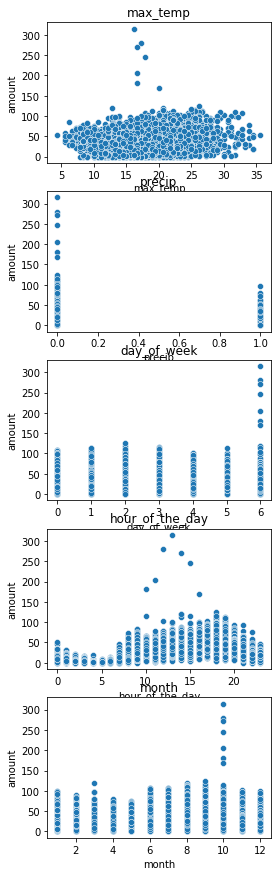

In [67]:
# plt.subplot syntax: (# of rows, # of columns, plot number)


Fig_4, axes = plt.subplots(nrows = 5, ncols = 1, figsize= (4,15))

# subplot no. 1
plt.subplot(5,1,1)
plt.xlabel('max_temp')
plt.ylabel('amount')
plt.title('max_temp')
sns.scatterplot(x=weather_demand["max_temp"], y=weather_demand["amount"])

# subplot no. 2
plt.subplot(5,1,2)
plt.xlabel('precip')
plt.ylabel('amount')
plt.title('precip')
sns.scatterplot(x=weather_demand["precip"], y=weather_demand["amount"])

# subplot no. 3
plt.subplot(5,1,3)
plt.xlabel('day_of_week')
plt.ylabel('amount')
plt.title('day_of_week')
sns.scatterplot(x=weather_demand["day_of_week"], y=weather_demand["amount"])

# subplot no. 4
plt.subplot(5,1,4)
plt.xlabel('hour_of_the_day')
plt.ylabel('amount')
plt.title('hour_of_the_day')
sns.scatterplot(x=weather_demand["hour_of_the_day"], y=weather_demand["amount"])

# subplot no. 5
plt.subplot(5,1,5)
plt.xlabel('month')
plt.ylabel('amount')
plt.title('month')
sns.scatterplot(x=weather_demand["month"], y=weather_demand["amount"])


plt.show()

#### Saving the Dataset in the folder, so the other notebooks can use them:

In [68]:
weather_demand.to_pickle("feature_set.pkl")